In [2]:
using Plots, Statistics, NaNStatistics, LinearAlgebra, Serialization, ParticleFilters, StatsBase, Distributions

include("../utils/import.jl")
using .Import

include("../utils/figs.jl")
using .Figs

fig_directory = "../fig/"
filetype = ".png"
function save(name::String)
    savefig(fig_directory*name*filetype)
end

save (generic function with 1 method)

# LONG runs

**Parameters:**\
steps: 1000\
lookahead: 5\
runs: 20

_num items, arms, teachers: 3\
granularity of U and D: 3\
teacher betas: \[0.0, 0.01, 50.0\]\
state IDs: 1217, 1226, 1235, 1245, 4586, 4589, 4629, 4638, 4641, 1572, 1712, 3191, 3204, 3437, 3446, 3514, 3526, 3616, 4151, 4426_

**Algorithms:**\
ATS/active: select teachers and arms by solving POMDP\
passive: solve POMDP, but can't pick which teacher gets queried\
naive-X: act randomly for X steps, then always pull expected-best arm\
random: select teachers and arms randomly\
arms: pull arms randomly

**Variables:**\
discount: 0.9 (discounted) or 1.0 (undiscounted)\
horizon: finite or infinite\
rollout: random (all actions) or constrained (arm-only)

**Time:**\
active infinite: 2.5h\
passive infinite: 2.5h\
active finite: 3.5h\
passive finite: 3.5h\
random: 6m\
arms: 6m\
naive-50: 5m\
naive-100: 5m\
naive-200: 5m

In [3]:
# Experiment parameters
runs = 20
actions = ["C1", "C2", "C3", "B1", "B2", "B3", "B"]
afc, aic, aiu, pfc, pic = "active finite", "active infinite", "active infinite (unconstrained)", "passive finite", "passive infinite"
r, ra, n50, n100, n200 = "random", "random arms", "naive-50", "naive-100", "naive-200"
aicn, picn, n50n = "active infinite negative", "passive infinite negative", "naive-50 negative"

# Plotting Parameters
labels = [afc aic aiu pfc pic r ra n50 n100 n200]
discount = 0.999
window = 10
;

In [14]:
## Previous experiments ##

# afc: active, finite, constrained
ids_afc = ["active_finite_23331_22581", "active_finite_23331_230912", "active_finite_23331_23194", "active_finite_23331_232832", "active_finite_23331_233745", "active_finite_23331_234620", "active_finite_23331_235559", "active_finite_2341_00042", "active_finite_2341_001352", "active_finite_2341_002354", "active_finite_2341_003143", "active_finite_2341_003937", "active_finite_2341_004937", "active_finite_2341_005730", "active_finite_2341_010754", "active_finite_2341_011826", "active_finite_2341_012934", "active_finite_2341_013739", "active_finite_2341_014528", "active_finite_2341_015325"]

# aic: active, infinite, constrained
ids_aic = ["active_infinite_23331_173929", "active_infinite_23331_174758", "active_infinite_23331_175550", "active_infinite_23331_180158", "active_infinite_23331_180838", "active_infinite_23331_18164", "active_infinite_23331_182331", "active_infinite_23331_183051", "active_infinite_23331_183832", "active_infinite_23331_18475", "active_infinite_23331_185539", "active_infinite_23331_190344", "active_infinite_23331_191151", "active_infinite_23331_19184", "active_infinite_23331_192554", "active_infinite_23331_194737", "active_infinite_23331_195422", "active_infinite_23331_200216", "active_infinite_23331_200820", "active_infinite_23331_201429"] 

# aiu: active, infinite, unconstrained
ids_aiu = ["active_infinite_2347_133639", "active_infinite_2347_13454", "active_infinite_2347_135340", "active_infinite_2347_140151", "active_infinite_2347_140951", "active_infinite_2347_141812", "active_infinite_2347_142648", "active_infinite_2347_14330", "active_infinite_2347_14415", "active_infinite_2347_144835", "active_infinite_2347_145636", "active_infinite_2347_150256", "active_infinite_2347_150911", "active_infinite_2347_151523", "active_infinite_2347_152138", "active_infinite_2347_152759", "active_infinite_2347_153611", "active_infinite_2347_154229", "active_infinite_2347_155045", "active_infinite_2347_155836"]

# pfc: passive, finite, constrained
ids_pfc = ["passive_finite_2341_020331", "passive_finite_2341_021258", "passive_finite_2341_022038", "passive_finite_2341_022957", "passive_finite_2341_023919", "passive_finite_2341_024851", "passive_finite_2341_02583", "passive_finite_2341_030527", "passive_finite_2341_031352", "passive_finite_2341_032256", "passive_finite_2341_033150", "passive_finite_2341_034040", "passive_finite_2341_034844", "passive_finite_2341_03568", "passive_finite_2341_040431", "passive_finite_2341_041158", "passive_finite_2341_041938", "passive_finite_2341_042739", "passive_finite_2341_04373", "passive_finite_2341_044432"]

# pic: passive, infinite, constrained
ids_pic = ["passive_infinite_23331_202225", "passive_infinite_23331_202939", "passive_infinite_23331_203640", "passive_infinite_23331_204346", "passive_infinite_23331_20514", "passive_infinite_23331_205811", "passive_infinite_23331_21041", "passive_infinite_23331_211040", "passive_infinite_23331_211639", "passive_infinite_23331_21247", "passive_infinite_23331_212956", "passive_infinite_23331_213613", "passive_infinite_23331_214235", "passive_infinite_23331_215023", "passive_infinite_23331_215646", "passive_infinite_23331_220450", "passive_infinite_23331_221250", "passive_infinite_23331_222018", "passive_infinite_23331_222659", "passive_infinite_23331_223256"]

# r: random
ids_r = ["random_2343_12335", "random_2343_123324", "random_2343_123344", "random_2343_12345", "random_2343_123425", "random_2343_123444", "random_2343_12354", "random_2343_123524", "random_2343_123543", "random_2343_12364", "random_2343_123624", "random_2343_123645", "random_2343_12375", "random_2343_123724", "random_2343_123745", "random_2343_12385", "random_2343_123825", "random_2343_123845", "random_2343_12395", "random_2343_123925"]

# ra: random arms
ids_ra = ["arms_2343_12539", "arms_2343_125329", "arms_2343_125349", "arms_2343_12549", "arms_2343_125428", "arms_2343_125448", "arms_2343_12558", "arms_2343_125527", "arms_2343_125547", "arms_2343_12567", "arms_2343_125627", "arms_2343_125646", "arms_2343_12576", "arms_2343_125726", "arms_2343_125745", "arms_2343_12584", "arms_2343_125823", "arms_2343_125842", "arms_2343_12592", "arms_2343_125921"]

# n50: naive with explore_timesteps = 50
ids_n50 = ["naive_50_2347_121158", "naive_50_2347_121215", "naive_50_2347_121232", "naive_50_2347_121249", "naive_50_2347_12136", "naive_50_2347_121323", "naive_50_2347_121339", "naive_50_2347_121356", "naive_50_2347_121414", "naive_50_2347_121431", "naive_50_2347_121448", "naive_50_2347_12155", "naive_50_2347_121523", "naive_50_2347_121540", "naive_50_2347_121557", "naive_50_2347_121614", "naive_50_2347_121631", "naive_50_2347_121648", "naive_50_2347_12175", "naive_50_2347_121722"]

# n100: naive with explore_timesteps = 100
ids_n100 = ["naive_100_2347_121858", "naive_100_2347_121914", "naive_100_2347_121931", "naive_100_2347_121948", "naive_100_2347_12205", "naive_100_2347_122022", "naive_100_2347_122039", "naive_100_2347_122056", "naive_100_2347_122112", "naive_100_2347_122129", "naive_100_2347_122146", "naive_100_2347_12222", "naive_100_2347_122219", "naive_100_2347_122236", "naive_100_2347_122253", "naive_100_2347_12239", "naive_100_2347_122326", "naive_100_2347_122343", "naive_100_2347_12240", "naive_100_2347_122417"]

# n200: naive with explore_timesteps = 200
ids_n200 = ["naive_200_2347_122512", "naive_200_2347_122528", "naive_200_2347_122545", "naive_200_2347_12261", "naive_200_2347_122617", "naive_200_2347_122634", "naive_200_2347_122650", "naive_200_2347_12276", "naive_200_2347_122723", "naive_200_2347_122739", "naive_200_2347_122756", "naive_200_2347_122812", "naive_200_2347_122828", "naive_200_2347_122845", "naive_200_2347_12291", "naive_200_2347_122918", "naive_200_2347_122934", "naive_200_2347_122950", "naive_200_2347_12307", "naive_200_2347_123023"]

## Harder ##

# aicn: active, infinite, constrained, teacher reward is negative
ids_aicn = ["active_infinite_2347_171839", "active_infinite_2347_172659", "active_infinite_2347_173451", "active_infinite_2347_174258", "active_infinite_2347_174934", "active_infinite_2347_17580", "active_infinite_2347_180538", "active_infinite_2347_18137", "active_infinite_2347_181935", "active_infinite_2347_182730", "active_infinite_2347_183339", "active_infinite_2347_184111", "active_infinite_2347_184857", "active_infinite_2347_185643", "active_infinite_2347_19031", "active_infinite_2347_191035", "active_infinite_2347_191822", "active_infinite_2347_192559", "active_infinite_2347_193348", "active_infinite_2347_194139"]

# picn: passive, infinite, constrained, teacher reward is negative
ids_picn = ["passive_infinite_2347_21368", "passive_infinite_2347_21421", "passive_infinite_2347_214853", "passive_infinite_2347_215556", "passive_infinite_2347_220311", "passive_infinite_2347_22093", "passive_infinite_2347_221617", "passive_infinite_2347_222210", "passive_infinite_2347_222926", "passive_infinite_2347_22374", "passive_infinite_2347_224252", "passive_infinite_2347_224951", "passive_infinite_2347_225625", "passive_infinite_2347_230323", "passive_infinite_2347_230920", "passive_infinite_2347_231640", "passive_infinite_2347_232346", "passive_infinite_2347_23316", "passive_infinite_2347_23388", "passive_infinite_2347_234416"]

# n50n: naive with explore_timesteps = 50, teacher reward is negative
ids_n50n = ["naive_50_2348_14268", "naive_50_2348_142625", "naive_50_2348_142642", "naive_50_2348_142659", "naive_50_2348_142716", "naive_50_2348_142733", "naive_50_2348_142749", "naive_50_2348_14287", "naive_50_2348_142824", "naive_50_2348_142842", "naive_50_2348_142859", "naive_50_2348_142915", "naive_50_2348_142933", "naive_50_2348_142950", "naive_50_2348_14307", "naive_50_2348_143024", "naive_50_2348_143041", "naive_50_2348_143058", "naive_50_2348_143115", "naive_50_2348_143132"]

s_afc, t_afc, a_afc, r_afc = Import.import_IDs(ids_afc, runs, directory="..")
s_aic, t_aic, a_aic, r_aic = Import.import_IDs(ids_aic, runs, directory="..")
s_aiu, t_aiu, a_aiu, r_aiu = Import.import_IDs(ids_aiu, runs, directory="..")
s_pfc, t_pfc, a_pfc, r_pfc = Import.import_IDs(ids_pfc, runs, directory="..")
s_pic, t_pic, a_pic, r_pic = Import.import_IDs(ids_pic, runs, directory="..")
s_r, t_r, a_r, r_r = Import.import_IDs(ids_r, runs, directory="..")
s_ra, t_ra, a_ra, r_ra = Import.import_IDs(ids_ra, runs, directory="..")
s_n50, t_n50, a_n50, r_n50 = Import.import_IDs(ids_n50, runs, directory="..")
s_n100, t_n100, a_n100, r_n100 = Import.import_IDs(ids_n100, runs, directory="..")
s_n200, t_n200, a_n200, r_n200 = Import.import_IDs(ids_n200, runs, directory="..")

s_aicn, t_aicn, a_aicn, r_aicn = Import.import_IDs(ids_aicn, runs, directory="..")
s_picn, t_picn, a_picn, r_picn = Import.import_IDs(ids_picn, runs, directory="..")
s_n50n, t_n50n, a_n50n, r_n50n = Import.import_IDs(ids_n50n, runs, directory="..")
;

In [13]:
j = 2
for i in 1:length(r_aicn[j])
    println(a_aicn[j][i], " ", r_aicn[j][i])
end

C2 0.0
C2 0.0
C2 0.0
C1 2.5
C2 0.0
C1 2.5
C1 2.5
C1 2.5
C2 0.0
C3 0.0
C1 2.5
C1 2.5
C1 2.5
C1 2.5
C2 0.0
C3 0.0
C2 0.0
C1 2.5
C1 2.5
C1 2.5
C2 0.0
C2 0.0
C1 2.5
C3 0.0
C2 0.0
C2 0.0
C2 0.0
C1 2.5
C3 0.0
C1 2.5
C3 0.0
C3 0.0
C1 2.5
B1 -1.0
C3 0.0
C3 0.0
C3 0.0
C1 2.5
C3 0.0
C2 0.0
C2 0.0
C2 0.0
C2 0.0
C3 0.0
C1 2.5
C3 0.0
C3 0.0
C2 0.0
C1 2.5
C2 0.0
C3 0.0
C2 0.0
C1 2.5
C2 0.0
C2 0.0
C1 2.5
C2 0.0
C3 0.0
C2 0.0
B2 -1.0
C2 0.0
C1 2.5
C2 0.0
C1 2.5
C3 0.0
C1 2.5
C1 2.5
C2 0.0
C3 0.0
B3 -1.0
C2 0.0
C2 0.0
C3 0.0
C1 2.5
C3 0.0
C1 2.5
C2 0.0
C1 2.5
C2 0.0
C3 0.0
C3 0.0
C2 0.0
C1 2.5
C3 0.0
C3 0.0
C1 2.5
C2 0.0
C3 0.0
C2 0.0
C3 0.0
C2 0.0
B3 -1.0
C1 2.5
C1 2.5
C2 0.0
C2 0.0
C3 0.0
C1 2.5
B3 -1.0
C1 2.5
C1 2.5
C2 0.0
C1 2.5
C2 0.0
C3 0.0
C3 0.0
C2 0.0
C3 0.0
C1 2.5
C1 2.5
B3 -1.0
B3 -1.0
C1 2.5
C1 2.5
C3 0.0
C1 2.5
C3 0.0
C1 2.5
C1 2.5
C3 0.0
C1 2.5
C1 2.5
C1 2.5
C1 2.5
C1 2.5
C3 0.0
C1 2.5
C1 2.5
C1 2.5
C3 0.0
C1 2.5
C1 2.5
C1 2.5
C3 0.0
C2 0.0
C1 2.5
C3 0.0
C1 2.5
C1 2.5
C1 2.5
C1 2.5
C1 2.5

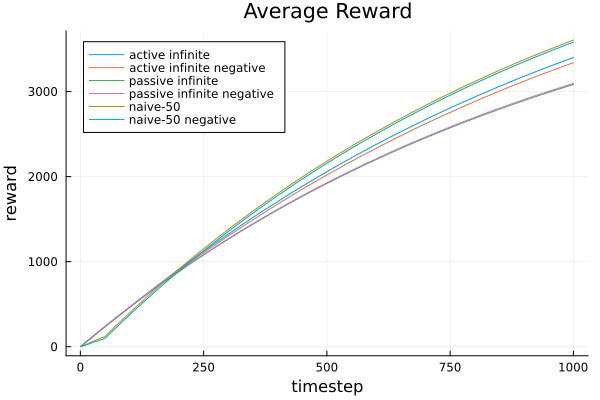

In [15]:
r = [r_aic, r_aicn, r_pic, r_picn, r_n50, r_n50n]
labels = [aic aicn pic picn n50 n50n]
Figs.plot_cumulative_avg_r_multiple_experiments(r, discount, labels, "Average Reward")

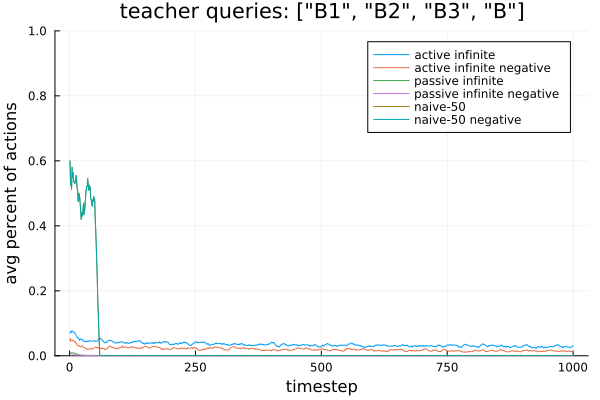

In [17]:
a = [a_aic, a_aicn, a_pic, a_picn, a_n50, a_n50n]
labels = [aic aicn pic picn n50 n50n]
Figs.plot_actions_in_list_rolling_multiple_experiments(a, ["B1", "B2", "B3", "B"], window, labels, "teacher queries: ")

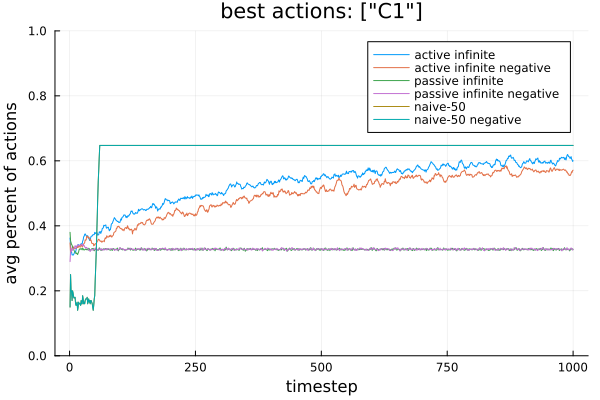

In [19]:
a = [a_aic, a_aicn, a_pic, a_picn, a_n50, a_n50n]
labels = [aic aicn pic picn n50 n50n]
Figs.plot_actions_in_list_rolling_multiple_experiments(a, ["C1"], window, labels, "best actions: ")

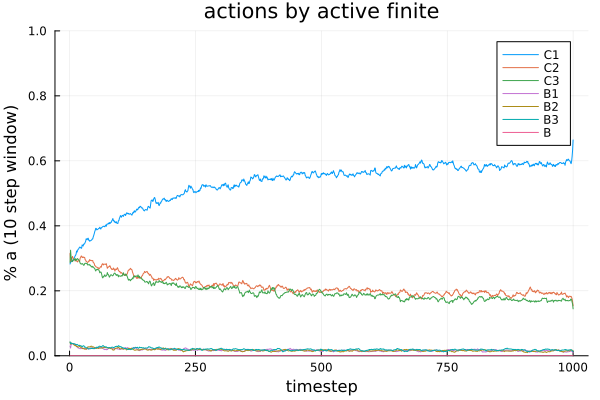

In [52]:
alg = afc
act = a_afc
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)

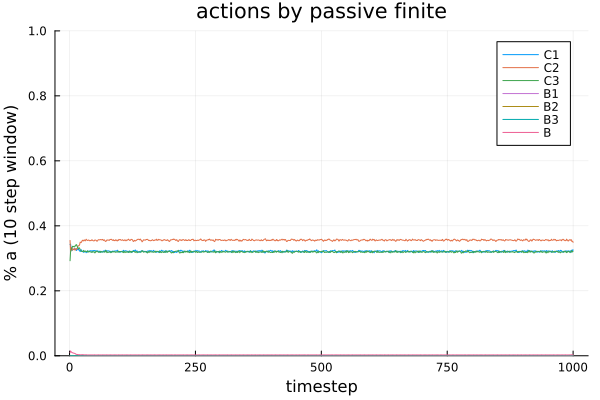

In [53]:
alg = pfc
act = a_pfc
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)